# Fake News Classification with NLP

In [2]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.impute import SimpleImputer

## Load and Preprocess Data

In [3]:

# Load dataset
train_df = pd.read_csv("liar_dataset/train.tsv", delimiter="\t", header=None)
test_df = pd.read_csv("liar_dataset/test.tsv", delimiter="\t", header=None)

# Define column names
column_names = [
    "ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job",
    "State", "Party", "Barely_True_Count", "False_Count", "Half_True_Count",
    "Mostly_True_Count", "Pants_On_Fire_Count", "Context"
]
train_df.columns = column_names
test_df.columns = column_names

# Handle NaNs
numeric_features = ["Barely_True_Count", "False_Count", "Half_True_Count", "Mostly_True_Count", "Pants_On_Fire_Count"]
train_df = train_df.dropna(subset=numeric_features)
test_df = test_df.dropna(subset=numeric_features)

categorical_features = ["Speaker", "Speaker_Job", "State", "Party", "Subject", "Context"]
train_df[categorical_features] = train_df[categorical_features].fillna("Unknown")
test_df[categorical_features] = test_df[categorical_features].fillna("Unknown")

## Feature Engineering

In [4]:
# Preprocessing function for statements
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    return text

train_df["Processed_Statement"] = train_df["Statement"].apply(preprocess_text)
test_df["Processed_Statement"] = test_df["Statement"].apply(preprocess_text)

# Simplify labels
label_mapping = {
    "true": "true", "mostly-true": "true",
    "half-true": "somewhat-true", "barely-true": "somewhat-true",
    "false": "false", "pants-fire": "false"
}
train_df["Simplified_Label"] = train_df["Label"].map(label_mapping)
test_df["Simplified_Label"] = test_df["Label"].map(label_mapping)

## Exploratory Data Analysis (EDA)

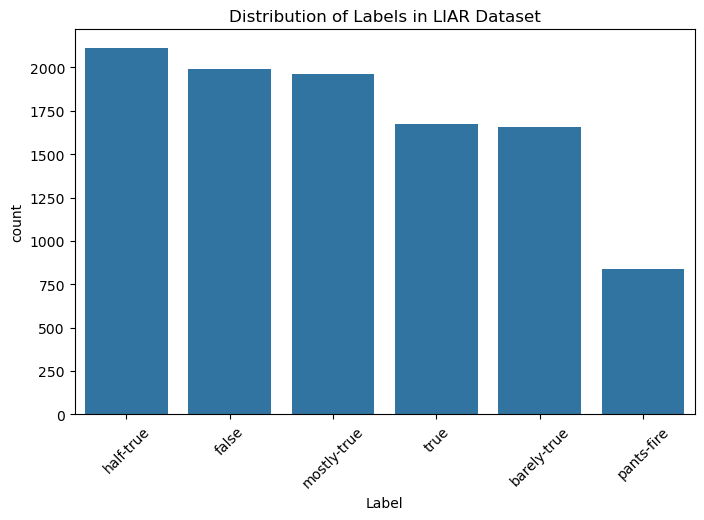

In [5]:
# Plot label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x="Label", order=train_df["Label"].value_counts().index)
plt.title("Distribution of Labels in LIAR Dataset")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_15365/4162792726.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="Simplified_Label", order=["false", "somewhat-true", "true"], palette=truthfulness_colors)


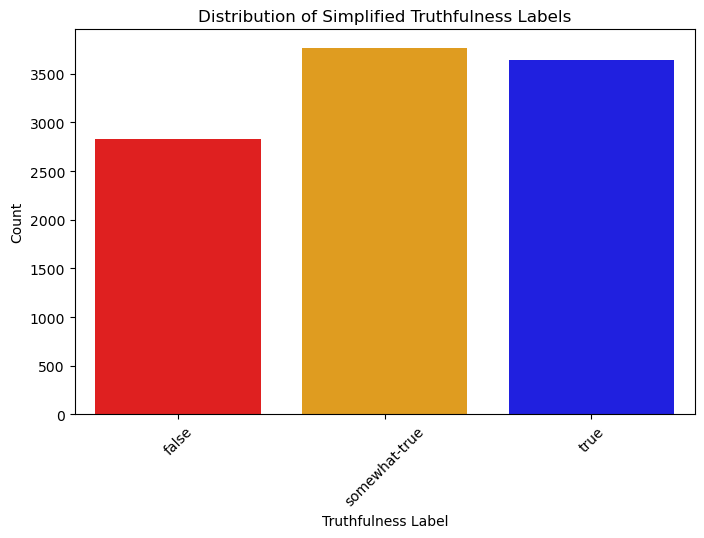

In [8]:
# Statement length column
train_df["Statement_Length"] = train_df["Statement"].apply(lambda x: len(str(x).split()))

# Color mapping for truthfulness
truthfulness_colors = {"false": "red", "somewhat-true": "orange", "true": "blue"}

# Label Distribution Analysis
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x="Simplified_Label", order=["false", "somewhat-true", "true"], palette=truthfulness_colors)
plt.title("Distribution of Simplified Truthfulness Labels")
plt.xlabel("Truthfulness Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_15365/1034616230.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")


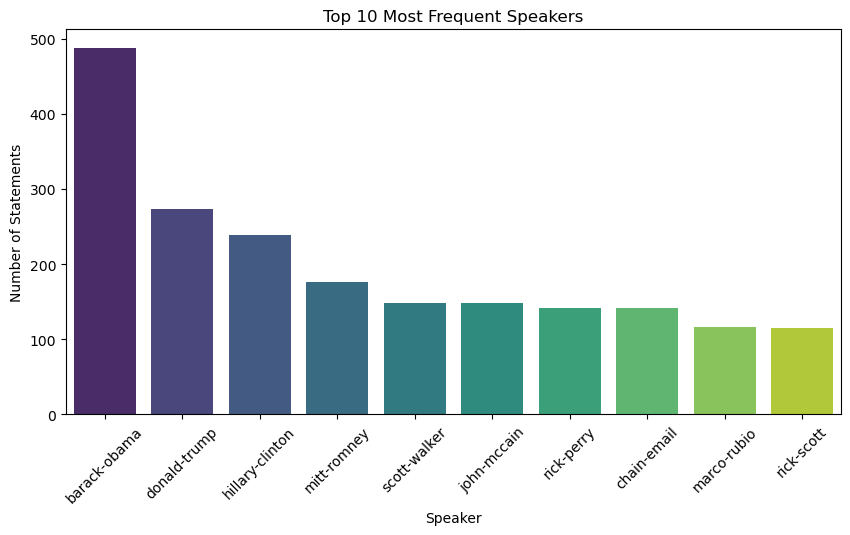

In [9]:
# Speaker Analysis: Most Frequent Speakers
top_speakers = train_df["Speaker"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")
plt.title("Top 10 Most Frequent Speakers")
plt.xlabel("Speaker")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45)
plt.show()

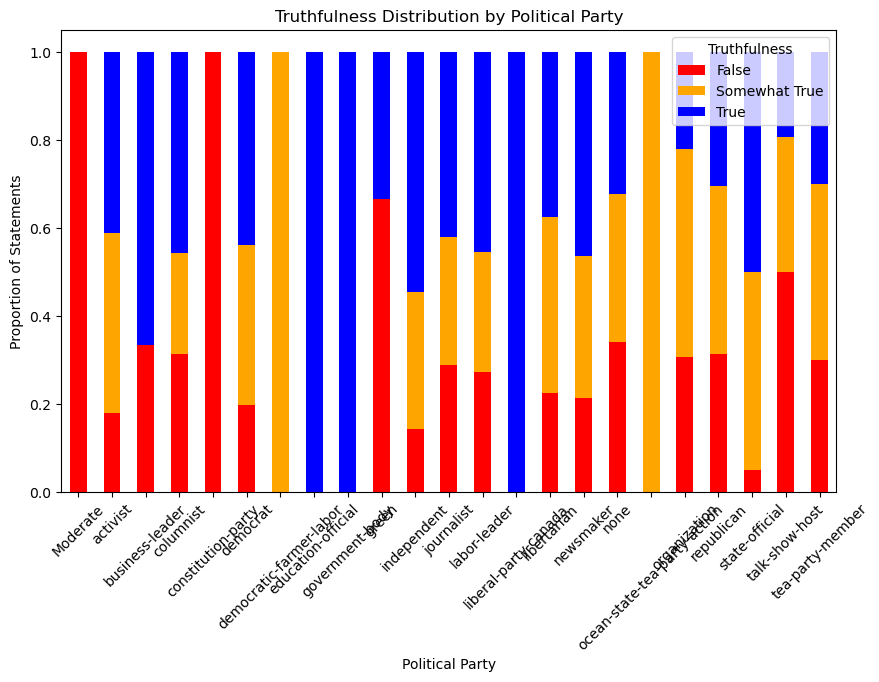

In [10]:
# Party Affiliation vs. Truthfulness
party_truth_table = pd.crosstab(train_df["Party"], train_df["Simplified_Label"], normalize="index")
party_truth_table.plot(kind="bar", stacked=True, figsize=(10, 6), color=[truthfulness_colors[label] for label in party_truth_table.columns])
plt.title("Truthfulness Distribution by Political Party")
plt.xlabel("Political Party")
plt.ylabel("Proportion of Statements")
plt.legend(title="Truthfulness", labels=["False", "Somewhat True", "True"])
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_15365/3302470076.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects.index, y=top_subjects.values, palette="coolwarm")


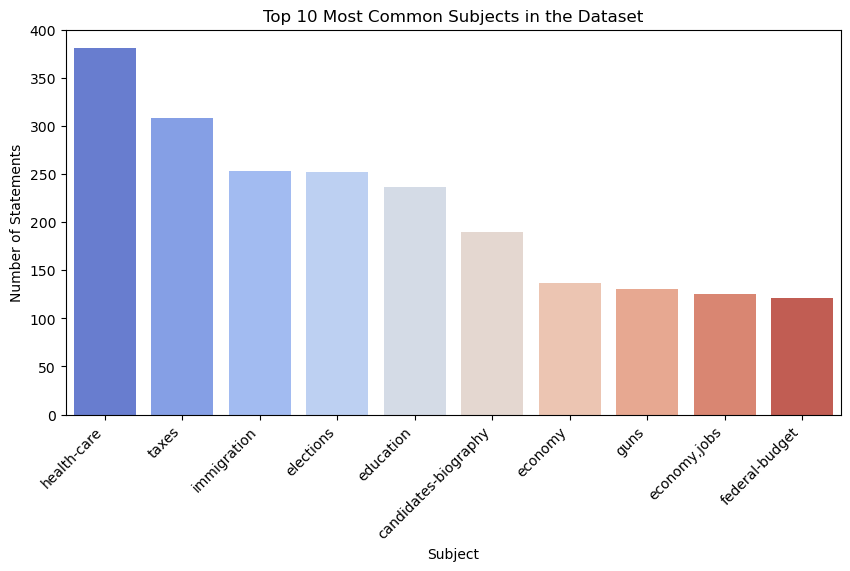

In [11]:
# Subject Analysis
top_subjects = train_df["Subject"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_subjects.index, y=top_subjects.values, palette="coolwarm")
plt.title("Top 10 Most Common Subjects in the Dataset")
plt.xlabel("Subject")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45, ha="right")
plt.show()

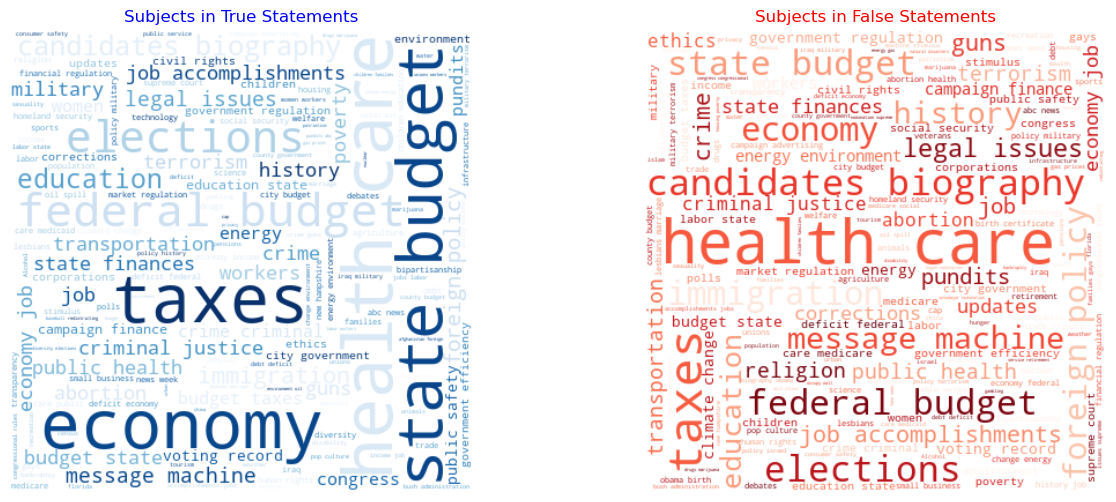

In [12]:
# Word Clouds
true_subjects = " ".join(train_df[train_df["Simplified_Label"] == "true"]["Subject"].dropna())
false_subjects = " ".join(train_df[train_df["Simplified_Label"] == "false"]["Subject"].dropna())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
wordcloud_true = WordCloud(width=400, height=400, background_color="white", colormap="Blues").generate(true_subjects)
axes[0].imshow(wordcloud_true, interpolation="bilinear")
axes[0].set_title("Subjects in True Statements", color="blue")
axes[0].axis("off")

wordcloud_false = WordCloud(width=400, height=400, background_color="white", colormap="Reds").generate(false_subjects)
axes[1].imshow(wordcloud_false, interpolation="bilinear")
axes[1].set_title("Subjects in False Statements", color="red")
axes[1].axis("off")

plt.show()

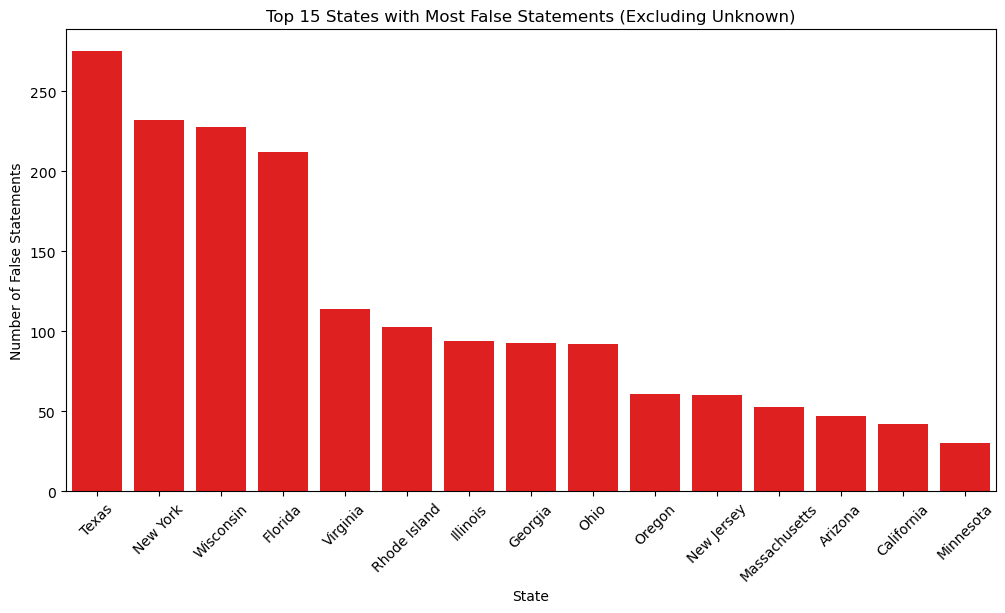

In [13]:
# State-Level Trends (False Statements) - Removing "Unknown"

# Count false statements per state and remove "Unknown"
false_statements_by_state = train_df[train_df["Simplified_Label"] == "false"]["State"].value_counts()
false_statements_by_state = false_statements_by_state[false_statements_by_state.index != "Unknown"].head(15)

# Plot updated bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=false_statements_by_state.index, y=false_statements_by_state.values, color="red")
plt.title("Top 15 States with Most False Statements (Excluding Unknown)")
plt.xlabel("State")
plt.ylabel("Number of False Statements")
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_15365/2681968054.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_jobs.index, y=top_jobs.values, palette="coolwarm")


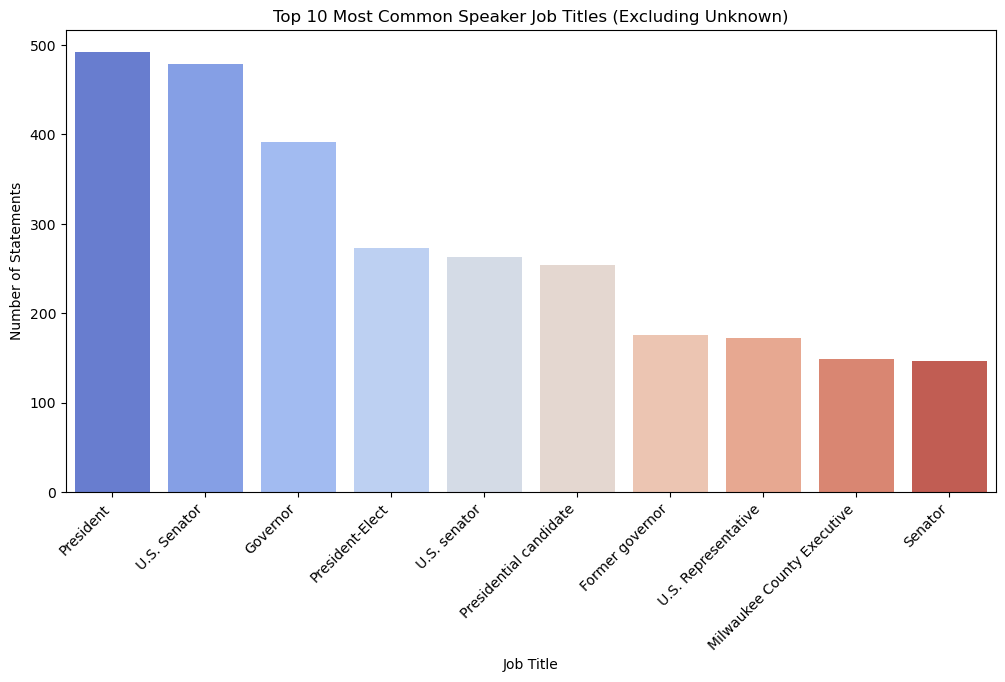

In [14]:
# Speaker Job Title Trends - Removing "Unknown"

# Remove "Unknown" job titles
top_jobs = train_df[train_df["Speaker_Job"] != "Unknown"]["Speaker_Job"].value_counts().head(10)

# Plot updated bar chart for top job titles
plt.figure(figsize=(12, 6))
sns.barplot(x=top_jobs.index, y=top_jobs.values, palette="coolwarm")
plt.title("Top 10 Most Common Speaker Job Titles (Excluding Unknown)")
plt.xlabel("Job Title")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45, ha="right")
plt.show()

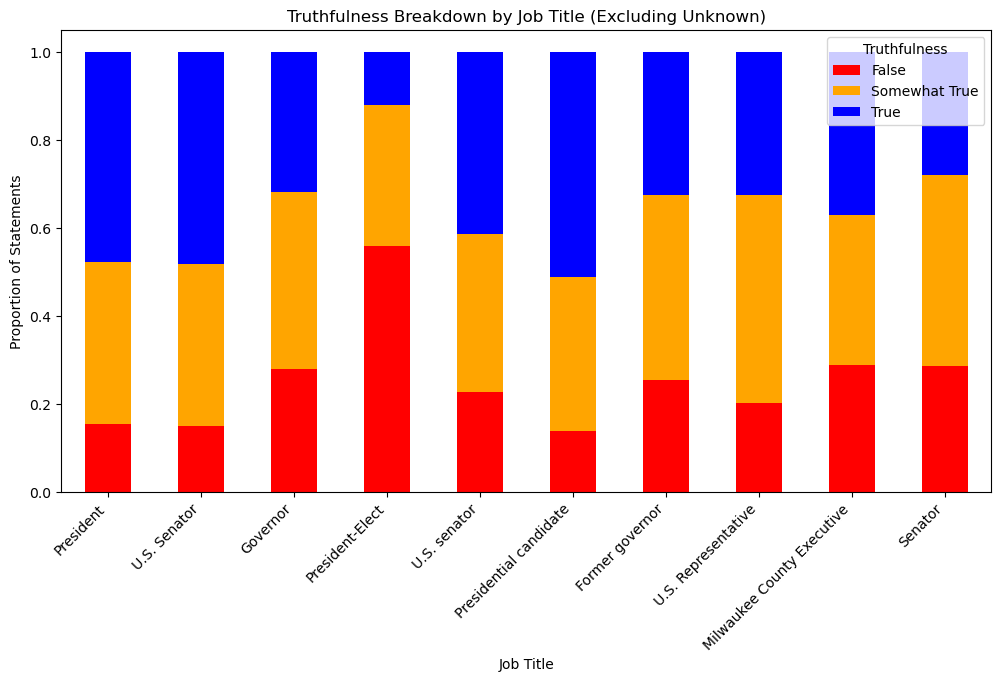

In [15]:
# Truthfulness breakdown by job title
job_truth_table = pd.crosstab(train_df["Speaker_Job"], train_df["Simplified_Label"], normalize="index")
job_truth_table = job_truth_table.loc[top_jobs.index]  # Filter only top 10 jobs

# Stacked bar chart with color coding
job_truth_table.plot(kind="bar", stacked=True, figsize=(12, 6), color=[truthfulness_colors[label] for label in job_truth_table.columns])
plt.title("Truthfulness Breakdown by Job Title (Excluding Unknown)")
plt.xlabel("Job Title")
plt.ylabel("Proportion of Statements")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Truthfulness", labels=["False", "Somewhat True", "True"])
plt.show()

## Logistic Regression Models

In [16]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Simplified_Label"])
y_test = label_encoder.transform(test_df["Simplified_Label"])

# Feature Extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Processed_Statement"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Processed_Statement"])

param_grid = {"C": [0.01, 0.1, 1, 10]}
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
log_reg.fit(X_train_tfidf, y_train)
y_pred = log_reg.predict(X_test_tfidf)
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline Logistic Regression Accuracy: 0.43567482241515393
              precision    recall  f1-score   support

           0       0.39      0.30      0.34       341
           1       0.44      0.45      0.44       477
           2       0.46      0.52      0.49       449

    accuracy                           0.44      1267
   macro avg       0.43      0.42      0.42      1267
weighted avg       0.43      0.44      0.43      1267



In [17]:
# Feature Extraction: Categorical Encoding
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
X_train_categorical = one_hot_encoder.fit_transform(train_df[categorical_features])
X_test_categorical = one_hot_encoder.transform(test_df[categorical_features])

# Feature Extraction: Numerical Scaling
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(train_df[numeric_features])
X_test_numeric = scaler.transform(test_df[numeric_features])

# Combine Features
X_train_combined = hstack([X_train_tfidf, X_train_categorical, X_train_numeric])
X_test_combined = hstack([X_test_tfidf, X_test_categorical, X_test_numeric])



# Logistic Regression Model Training
log_param_grid = {"C": [0.01, 0.1, 1, 10]}
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), log_param_grid, cv=5)
log_reg.fit(X_train_combined, y_train)

# Predictions
y_pred = log_reg.predict(X_test_combined)

# Evaluation
print("Best Logistic Regression Parameters:", log_reg.best_params_)
print("Logistic Regression Accuracy with Added Metadata:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Logistic Regression Parameters: {'C': 0.1}
Logistic Regression Accuracy with Added Metadata: 0.468034727703236
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       341
           1       0.45      0.45      0.45       477
           2       0.48      0.60      0.53       449

    accuracy                           0.47      1267
   macro avg       0.47      0.46      0.46      1267
weighted avg       0.47      0.47      0.46      1267



In [18]:
# Logistic Regression with TF-IDF (n-grams)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_train_tfidf_ngram = tfidf_vectorizer.fit_transform(train_df["Processed_Statement"])
X_test_tfidf_ngram = tfidf_vectorizer.transform(test_df["Processed_Statement"])

X_train_combined_ngram = hstack([X_train_tfidf_ngram, X_train_categorical, X_train_numeric])
X_test_combined_ngram = hstack([X_test_tfidf_ngram, X_test_categorical, X_test_numeric])

log_reg.fit(X_train_combined_ngram, y_train)
y_pred_log_ngram = log_reg.predict(X_test_combined_ngram)
print("Logistic Regression with TF-IDF (n-grams) Accuracy:", accuracy_score(y_test, y_pred_log_ngram))
print(classification_report(y_test, y_pred_log_ngram))

Logistic Regression with TF-IDF (n-grams) Accuracy: 0.46724546172059983
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       341
           1       0.45      0.45      0.45       477
           2       0.47      0.59      0.53       449

    accuracy                           0.47      1267
   macro avg       0.47      0.46      0.46      1267
weighted avg       0.47      0.47      0.46      1267



## Support Vector Machine

In [19]:
# Grid Search for SVM
svm_param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(X_train_combined, y_train)
best_svm_params = svm_grid_search.best_params_
print("Best SVM Parameters:", best_svm_params)

Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}


In [20]:
# Train SVM Model
svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train_combined, y_train)
y_pred_svm = svm_model.predict(X_test_combined)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.43962115232833465
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       341
           1       0.45      0.41      0.43       477
           2       0.45      0.51      0.48       449

    accuracy                           0.44      1267
   macro avg       0.44      0.44      0.44      1267
weighted avg       0.44      0.44      0.44      1267



## Random Forest

In [21]:

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [10, 15, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Perform Grid Search with 5-fold cross-validation
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_combined, y_train)

# Get the best parameters and the best model
best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best Random Forest model
y_pred_rf_best = best_rf_model.predict(X_test_combined)
rf_best_accuracy = accuracy_score(y_test, y_pred_rf_best)
rf_best_report = classification_report(y_test, y_pred_rf_best)

print("Random Forest Accuracy:", rf_best_accuracy)
print("Classification Report:\n", rf_best_report)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Accuracy: 0.5706393054459353
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.45      0.52       341
           1       0.53      0.60      0.56       477
           2       0.58      0.64      0.61       449

    accuracy                           0.57      1267
   macro avg       0.58      0.56      0.56      1267
weighted avg       0.58      0.57      0.57      1267

